<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, TimeSeriesSplit

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
r = 12345

In [2]:
df = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
df.head(7)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


Посмотрим на график всего временного ряда

In [4]:
def get_plot(x, y, ylabel, xlabel='Дата', title='Временной ряд', label=None, lw=0.8):
    plt.figure(figsize=(10, 7))
    plt.plot(x, y, linestyle='-', linewidth=lw, label=label)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

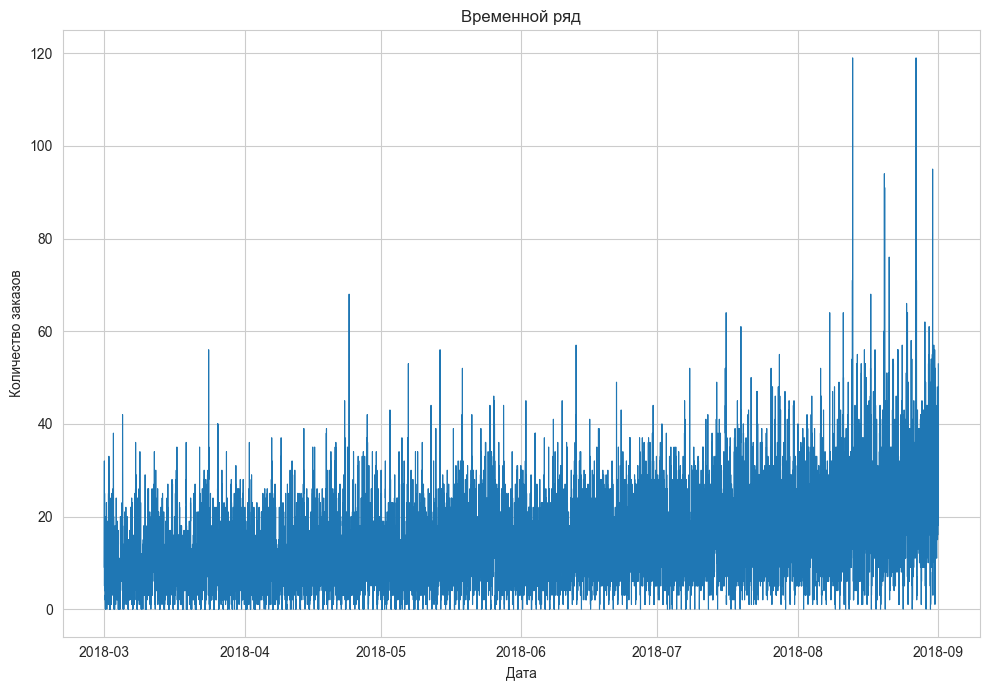

In [5]:
get_plot(df.index, df['num_orders'], ylabel='Количество заказов')

Ресемплируем временной ряд по 1 часу, просуммировав значения и построим график

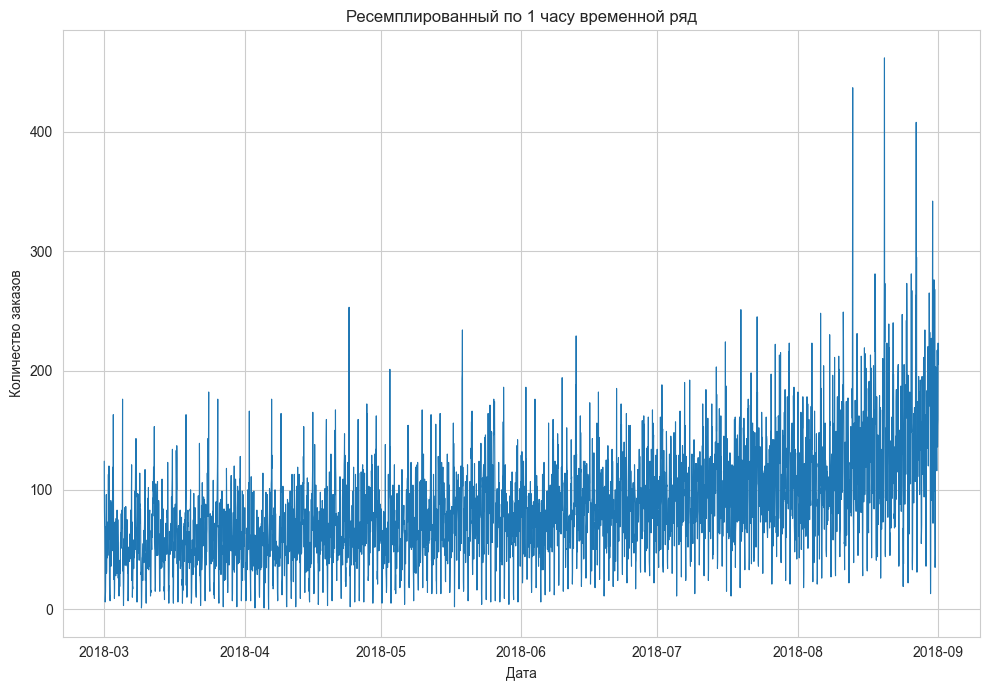

In [6]:
df = df.resample('1H').sum()
get_plot(df.index, df['num_orders'], ylabel='Количество заказов', title='Ресемплированный по 1 часу временной ряд')

In [7]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Проверим, что ряд монотонно возрастает и даты расположены в порядке возрастания

In [8]:
df.index.is_monotonic

True

## Анализ

Разложим временной ряд на тренд и сезонность

In [9]:
decomposed = seasonal_decompose(df)

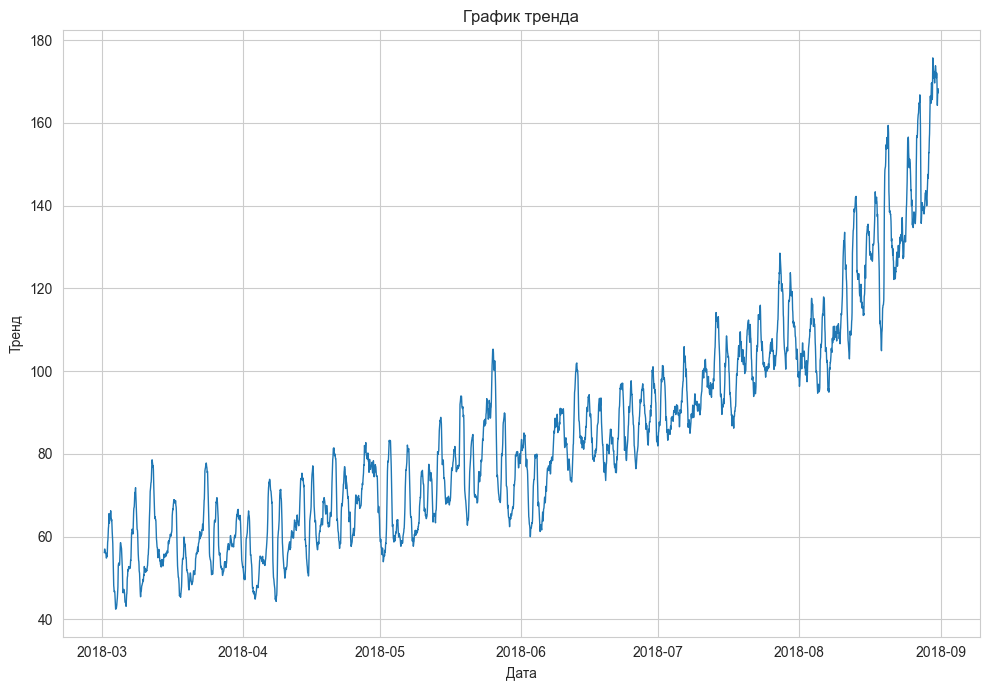

In [10]:
get_plot(df.index, decomposed.trend, ylabel='Тренд', title='График тренда', lw=1)

Наблюдается растущий тренд. С течением года среднее количество заказов растет линейно, но есть резкий скачок заказов такси в августе- сентябре. Возможно это связано с бОльшим количеством отпуском в этот период, но данных мало, чтобы это утверждать.  
По данным авиастат (за 2019-2021 год), https://www.aviastat.ru/statistics/123-aviaperevozka-passazhirov-v-rossii-itogi-2021-goda кол-во полетов в период до коронавируса и после с апреля по август пассажиропоток увеличивается. 
Возможно, это как-то связано с тем, что в нашем датасете наблюдается аналогичный рост. Было бы интересно посмотреть на данные за весь 2018 год и более для более глубокого анализа.

Посмотрим на сезонность ряда

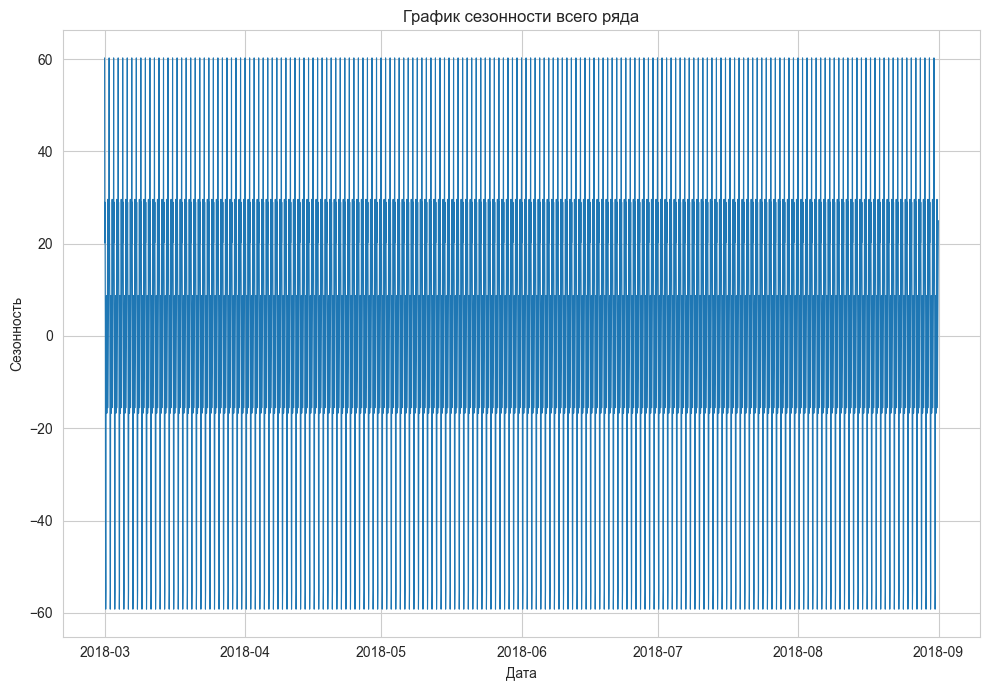

In [11]:
get_plot(df.index, decomposed.seasonal, ylabel='Сезонность', title='График сезонности всего ряда')

Очень не понятно на графике, возьмем небольшой период - сутки - если сезонность есть, этого будет достаточно

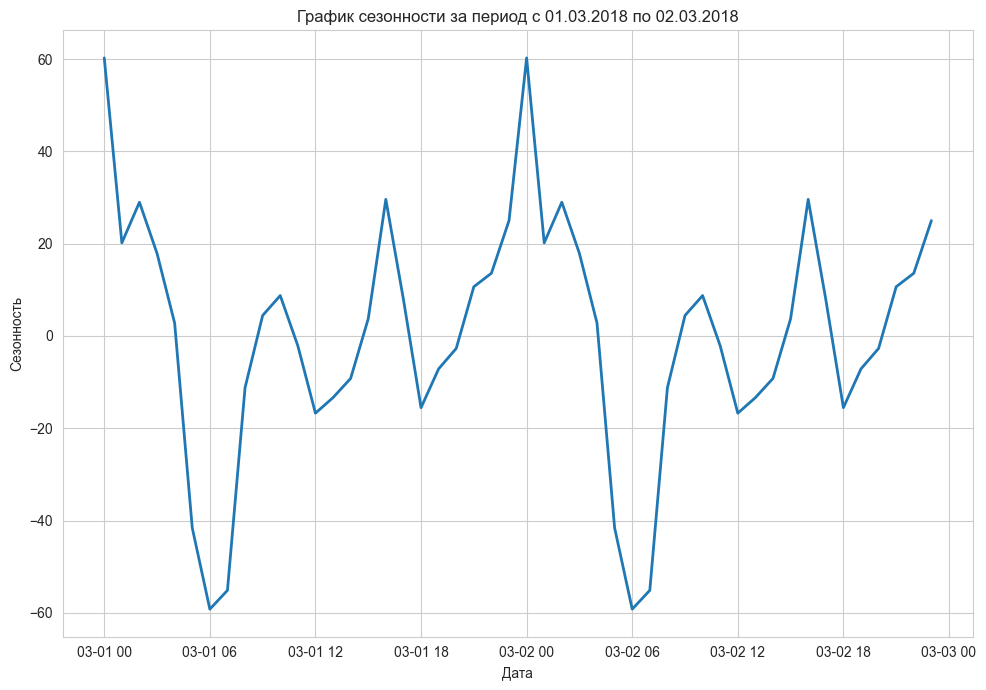

In [12]:
get_plot(df['2018-03-01':'2018-03-02'].index, decomposed.seasonal['2018-03-01':'2018-03-02'], 
         ylabel='Сезонность', title='График сезонности за период с 01.03.2018 по 02.03.2018',lw=2)

Наблюдается суточная сезонность.
Больше всего заказов около полуночи. (с 23:00 до 03:00), а также днем около 15:00. Меньше всего заказов около 6 утра.

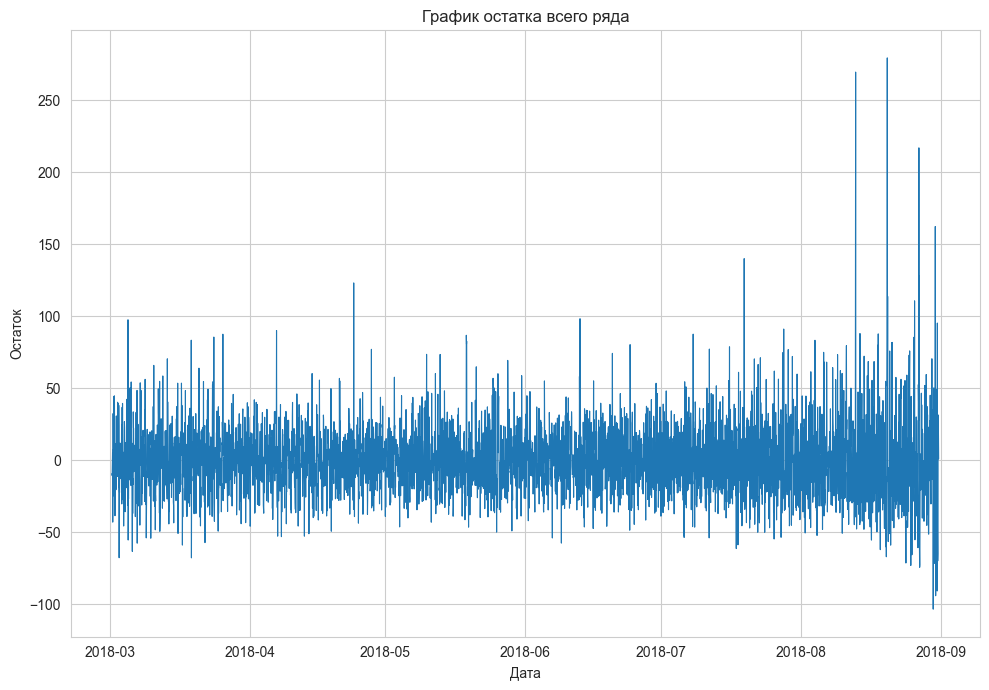

In [13]:
get_plot(df.index, decomposed.resid, ylabel='Остаток', title='График остатка всего ряда')

Шум данных почти на всем протяжении одинаков, но ближе в концу графика (примерно с августа) шум больше.

Так же попробуем ресемплировать по дням и посмотреть на сезонность/тренды в таком случае

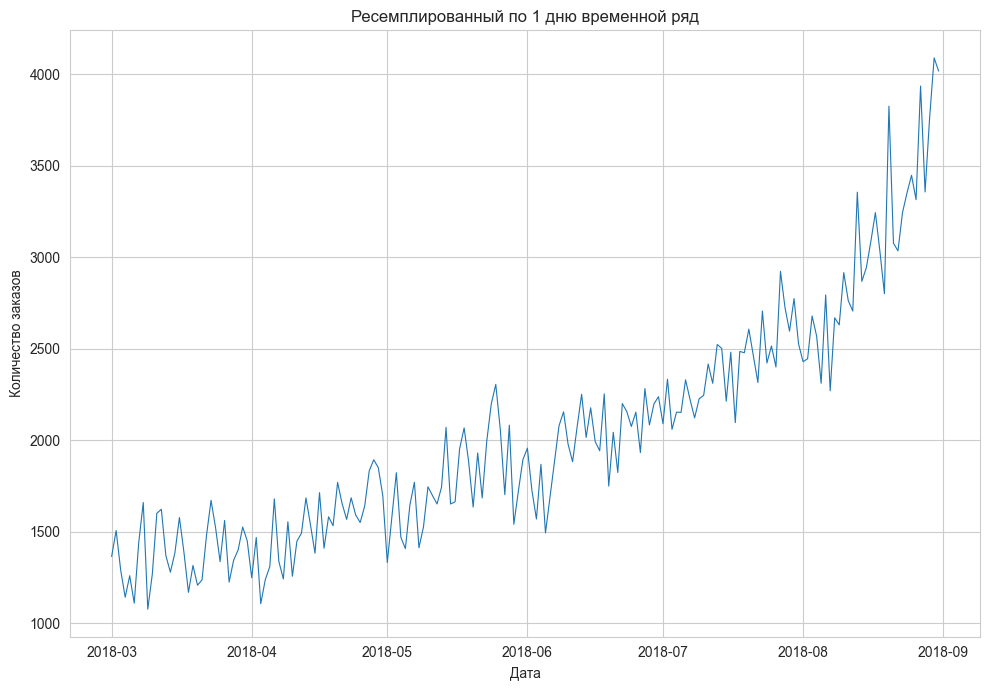

In [14]:
copied_df = df.copy()
copied_df = copied_df.resample('1D').sum()
get_plot(copied_df.index, copied_df['num_orders'], ylabel='Количество заказов', 
         title='Ресемплированный по 1 дню временной ряд')

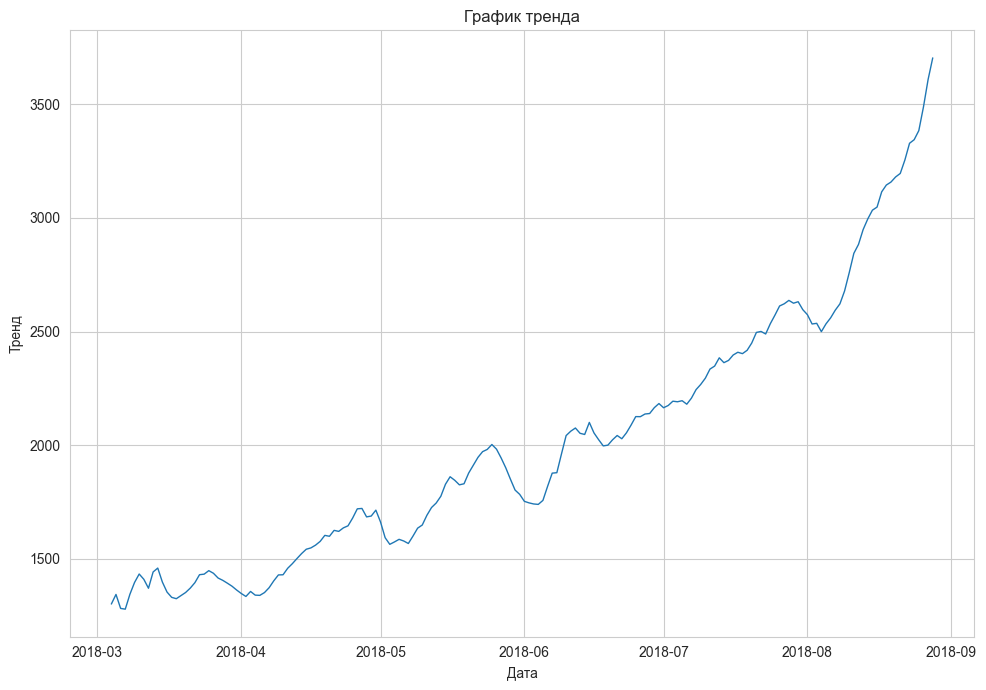

In [15]:
copied_df_decomposed = seasonal_decompose(copied_df)
get_plot(copied_df.index, copied_df_decomposed.trend, ylabel='Тренд', title='График тренда', lw=1) 

Тренд растет также

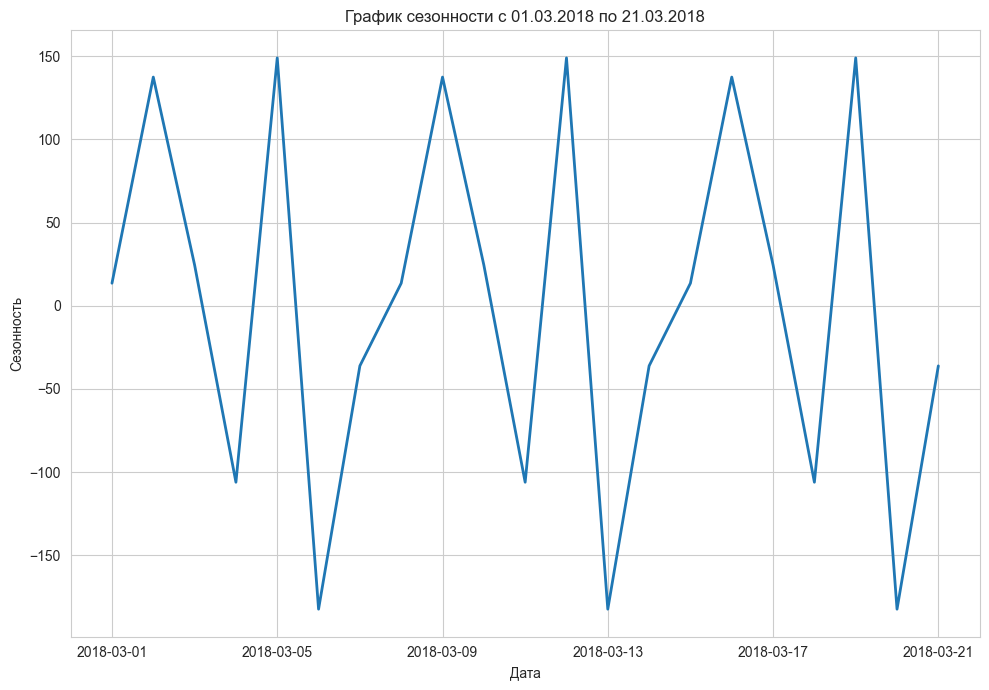

In [16]:
get_plot(copied_df['2018-03-01':'2018-03-21'].index, copied_df_decomposed.seasonal['2018-03-01':'2018-03-21'], 
         ylabel='Сезонность', title='График сезонности с 01.03.2018 по 21.03.2018',lw=2)

В ряду наблюдается недельная сезонность.
Больше всего заказов во вторник и пятницу, меньше всего заказов в четверг и субботу.

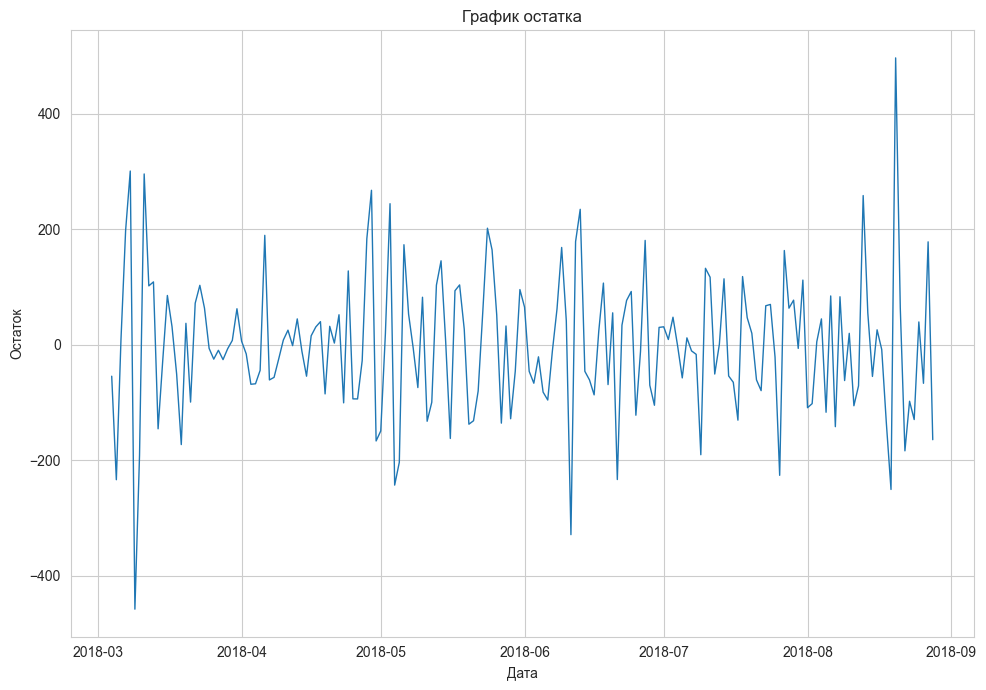

In [17]:
get_plot(copied_df.index, copied_df_decomposed.resid, ylabel='Остаток', title='График остатка', lw=1) 

Остаток примерно одинаков на всей продолжительности

## Обучение

Создадим признаки для обучения модели. Нам необходимо создать новые колонки с отстающими значениями (лагами). Так как у нас посуточная сезонность, то каждый час одних суток будет немного похож по динамике заказов на тот же час предыдущих суток (например, к 17:00 количество заказов увеличивается, к 00:00 еще, а к 6:00 падает до минимума, и так каждый день. Значит, нам понадобится 24-й лаг, который будет отражать суточную сезонность. Но так как у нас присутствует недельная сезонность, то нам будет очень важен 168-й лаг.

In [18]:
def make_features(raw_data, max_lag, rolling_mean_size):
    data = raw_data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [19]:
new_df = make_features(df, 168, 24)
new_df = new_df.dropna()
new_df.head(5)

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,47.0,81.0,58.0,83.0,48.0,51.0,52.0,42.0,63.0,40.0,42.0,41.0,48.0,51.0,52.0,25.0,10.0,7.0,36.0,30.0,49.0,36.0,75.0,42.0,47.0,72.0,42.0,40.0,37.0,86.0,37.0,59.0,45.0,58.0,37.0,85.0,62.0,50.0,59.0,31.0,14.0,3.0,16.0,34.0,51.0,32.0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,42.0,26.0,60.0,75.0,43.0,63.0,48.0,83.0,30.0,68.0,49.0,46.0,76.0,41.0,28.0,32.0,57.0,52.0,73.0,56.0,17.0,9.0,15.0,44.0,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,54.226190
2018-03-08 01:00:00,78,1,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,47.0,81.0,58.0,83.0,48.0,51.0,52.0,42.0,63.0,40.0,42.0,41.0,48.0,51.0,52.0,25.0,10.0,7.0,36.0,30.0,49.0,36.0,75.0,42.0,47.0,72.0,42.0,40.0,37.0,86.0,37.0,59.0,45.0,58.0,37.0,85.0,62.0,50.0,59.0,31.0,14.0,3.0,16.0,34.0,51.0,32.0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,42.0,26.0,60.0,75.0,43.0,63.0,48.0,83.0,30.0,68.0,49.0,46.0,76.0,41.0,28.0,32.0,57.0,52.0,73.0,56.0,17.0,9.0,15.0,44.0,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,54.339286
2018-03-08 02:00:00,65,2,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,47.0,81.0,58.0,83.0,48.0,51.0,52.0,42.0,63.0,40.0,42.0,41.0,48.0,51.0,52.0,25.0,10.0,7.0,36.0,30.0,49.0,36.0,75.0,42.0,47.0,72.0,42.0,40.0,37.0,86.0,37.0,59.0,45.0,58.0,37.0,85.0,62.0,50.0,59.0,31.0,14.0,3.0,16.0,34.0,51.0,32.0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,42.0,26.0,60.0,75.0,43.0,63.0,48.0,83.0,30.0,68.0,49.0,46.0,76.0,41.0,28.0,32.0,57.0,52.0,73.0,56.0,17.0,9.0,15.0,44.0,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0

Разделим ряд на треин и тест (10%), при этом удалим строки с пропусками в обучающей выборке, которые образовались при формировании сдвига

In [20]:
train, test = train_test_split(new_df, shuffle=False, test_size=0.1)
train = train.dropna()
train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

Рассмотрим 4 модели - LinearRegression, LGBMRegressor, RandomForest
Подберем лучшие гиперпараметры моделей и сравним rmse на этих гиперпараметрах.

In [21]:
lgbm = LGBMRegressor()
rf = RandomForestRegressor()
lr = LinearRegression()

In [22]:
rf_params = {'n_estimators': [100, 150],
             'max_depth': [4, 6, 8, 10],
             'min_samples_leaf': [1, 2, 3, 4, 5]}

lgbm_params = {
    'n_estimators': [100, 150],
    'max_depth': [8, 10, 12, 14],
    'learning_rate': [0.01, 0.1]}

In [23]:
def get_best_params(model, params, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(estimator=model, cv=tscv, param_grid=params, scoring='neg_mean_squared_error')
    grid.fit(X, y)
    print(f'rmse {model} = {(-grid.best_score_) ** 0.5}')
    print(f'best params {grid.best_params_}')
    best_params = grid.best_params_
    return best_params

In [24]:
%%time
rf_best_params = get_best_params(rf, rf_params, train_features, train_target)

rmse RandomForestRegressor() = 23.30211263681921
best params {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}
CPU times: user 36min 17s, sys: 12.4 s, total: 36min 29s
Wall time: 36min 57s


In [25]:
%%time
lgbm_best_params = get_best_params(lgbm, lgbm_params, train_features, train_target)

rmse LGBMRegressor() = 23.42708892710068
best params {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 100}
CPU times: user 3min 24s, sys: 6.59 s, total: 3min 31s
Wall time: 60 s


In [26]:
%%time
lr = get_best_params(lr, {}, train_features, train_target)

rmse LinearRegression() = 22.861225927882845
best params {}
CPU times: user 4.11 s, sys: 529 ms, total: 4.64 s
Wall time: 4.22 s


Лучшее значение на тренировочных данных показала модель линейной регрессии, протестируем ее

## Тестирование

In [33]:
model_lr = LinearRegression()
model_lr.fit(train_features, train_target)
linreg_test_preds = model_lr.predict(test_features)
print(f'RMSE linreg test : {abs(mean_squared_error(test_target, linreg_test_preds)) ** 0.5}\n')

RMSE linreg test : 34.260339620838124



На тестовых данных метрика rmse = 34.2. Что ниже порога в 48.
Интересно сравнить модель с предсказанием предыдущего значения.

In [34]:
pred_previous = test_target.shift()
pred_previous.iloc[0] = test_target.iloc[-1]
print(f'RMSE last test : {abs(mean_squared_error(test_target, pred_previous)) ** 0.5}\n')

RMSE last test : 59.27241199351863



Вывод

Мы провели анализ временного ряда данных о заказах такси в аэропортах.
Была обнаружена суточная сезонность - в течение дня люди заказывают такси в аэропортах неоднородно. Больше всего заказов с 23 до 3 утра, а так же днем около 15.00. Меньше всего заказов утром около 6 утра.

Так же была обнаружена недельная сезонность. Больше заказов - во вторник и пятницу, меньше - в четверг и субботу.
Наблюдается тренд - кол-во заказов такси в аэропортах растет с каждым месяцем линейно, а в августе скачок вверх.

После анализа данных были созданы признаки для модели: 168 лагов по часам и скользящее среднее в 24 часа. И отобрана лучшая модель для прогнозирования - линейная регрессия.